# Coefficients and Stats

## CURRENT STATUS:

### Stuck on ROC curve for each model, combined

1. Add section for seeing which ones are being classified wrong.
2. Lemmatizing
3. Bootstrapping

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, KFold

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, classification_report

import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [ ]:
# ==================== CONSTANTS ==================== #
seed = 7
np.random.seed(seed)

# list to get data for
subreddit_list = ["deeplearning", "tensorflow", "scikit_learn", "pandas", "bigdata", "aws", "awscertifications", "css", "html", "javascript", "shittyprogramming", "java", "sql", "learnsql", "postgresql", "softwarearchitecture"]



In [2]:
!pwd

/Users/chris/github/reddit_nlp


In [3]:
from util import databases
from util import dataloader
from util import grid_models
from util.reddit_functions import Reddit, Visualizer, Labeler

In [4]:
!pwd

/Users/chris/github/reddit_nlp/util


In [25]:
# load data using dataloader module
df = dataloader.data_selector(subreddit_list, source='sqlite')

# what we expected?
avg_posts = []
for sub in subreddit_list:
    posts_length = len(df[df['subreddit'] == sub])
    print(sub, posts_length)
    avg_posts.append(posts_length)
    
print(f'Average post length: {np.mean(avg_posts)}')

df.info()
df.sample(10)

Connection to SQLite DB successful
deeplearning 6692
tensorflow 6758
scikit_learn 675
pandas 1135
bigdata 3864
aws 6982
awscertifications 6774
css 6390
html 6780
javascript 6467
shittyprogramming 6944
java 5691
sql 6780
learnsql 6663
postgresql 6936
softwarearchitecture 6303
Average post length: 5739.625
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91834 entries, 0 to 91833
Data columns (total 3 columns):
title        91834 non-null object
subreddit    91834 non-null object
date         91834 non-null object
dtypes: object(3)
memory usage: 2.1+ MB


,title,subreddit,date
76375,Would appreciate some pointers and feedback ab...,learnsql,2020-04-21
54723,Would you be interested in reading a career si...,bigdata,2020-04-20
62054,Create Table in Oracle Tutorial,sql,2020-04-20
2837,[Step Functions] Can't find error in my InputPath,aws,2020-03-29
43368,Is AWS Study Guide book important for passing ...,awscertifications,2020-04-14
61916,To get only the last date’s value for each mon...,sql,2020-04-20
60905,If I don't let my filesystems age 18 years bef...,shittyprogramming,2020-04-20
40612,[Tutorial] Solving overfitting in neural nets,tensorflow,2020-04-14
35023,Hazelcast with Spring Boot on Kubernetes,java,2020-04-10
29690,Securing a Websocket URL,aws,2020-04-10


In [7]:
X = df['title']
y = df['subreddit']

In [8]:
useless_words = set(['postgres', 'big', 'panda', 'using', 'scikit', 'sklearn', 'apache', 'spark', 'lambda', 's3', 'does', 'looking', 'help', 'new', 'data', 'science', 'scientist', 'machine', 'learning', 'use', 'need', 'engineer', 'engineering'])

custom_stop_words = ENGLISH_STOP_WORDS.union(subreddit_list, useless_words)

In [9]:
# lemmatizer? for scientist vs scientists

In [10]:
tfidf = TfidfVectorizer(max_df=0.7, max_features=6000, ngram_range=(1,2), stop_words=custom_stop_words)
labeler = Labeler()
model = LogisticRegression(max_iter=1000, multi_class='ovr')
# pipe = Pipeline([('tfidf', tfidf),('logreg', logreg)])

In [11]:
# bootstrapping?

In [ ]:
pop = np.random.randint(0,500 , size=1000)
sample = np.random.choice(pop, size=300) #so n=300

In [ ]:
sample_mean = []
for _ in range(10000):  #so B=10000
    sample_n = np.random.choice(sample, size=300)
    sample_mean.append(sample_n.mean())

In [ ]:
np.mean(sample_mean)

pop.mean()

sample.mean()

In [12]:
X = tfidf.fit_transform(X)
labeler.fit(y)
y = labeler.transform(y)
classes = labeler.classes_
labeler.encodings_

{'deeplearning': 0,
 'tensorflow': 1,
 'scikit_learn': 2,
 'pandas': 3,
 'bigdata': 4,
 'aws': 5,
 'awscertifications': 6,
 'css': 7,
 'html': 8,
 'javascript': 9,
 'shittyprogramming': 10,
 'java': 11,
 'sql': 12,
 'learnsql': 13,
 'postgresql': 14,
 'softwarearchitecture': 15}

In [ ]:
model.fit(X, y)
cross_val_score(model, X, y, cv=StratifiedKFold(shuffle=True, random_state=seed), n_jobs=-1)

# Coefficients

In [14]:
if hasattr(model, 'coef_'):
    coef_dict = {}
    for i, sub in enumerate(classes):
        coef_dict[sub] = pd.DataFrame(
                            data=model.coef_[i],
                            index=tfidf.get_feature_names()
                            )
else:
    print('Model does not have coefficients')

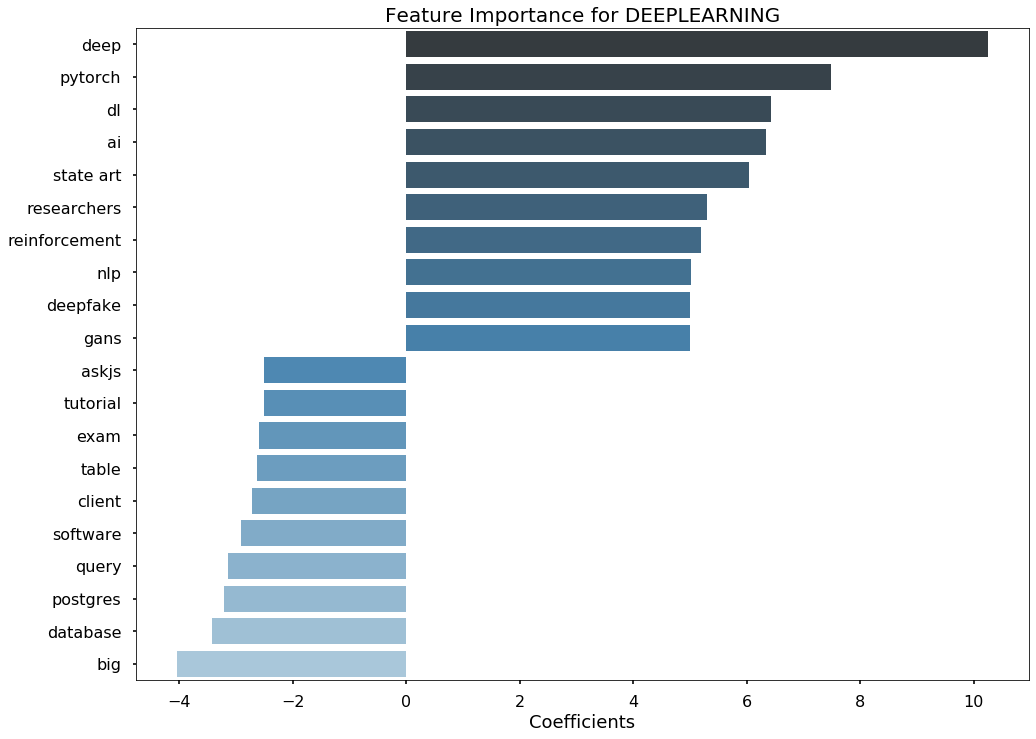

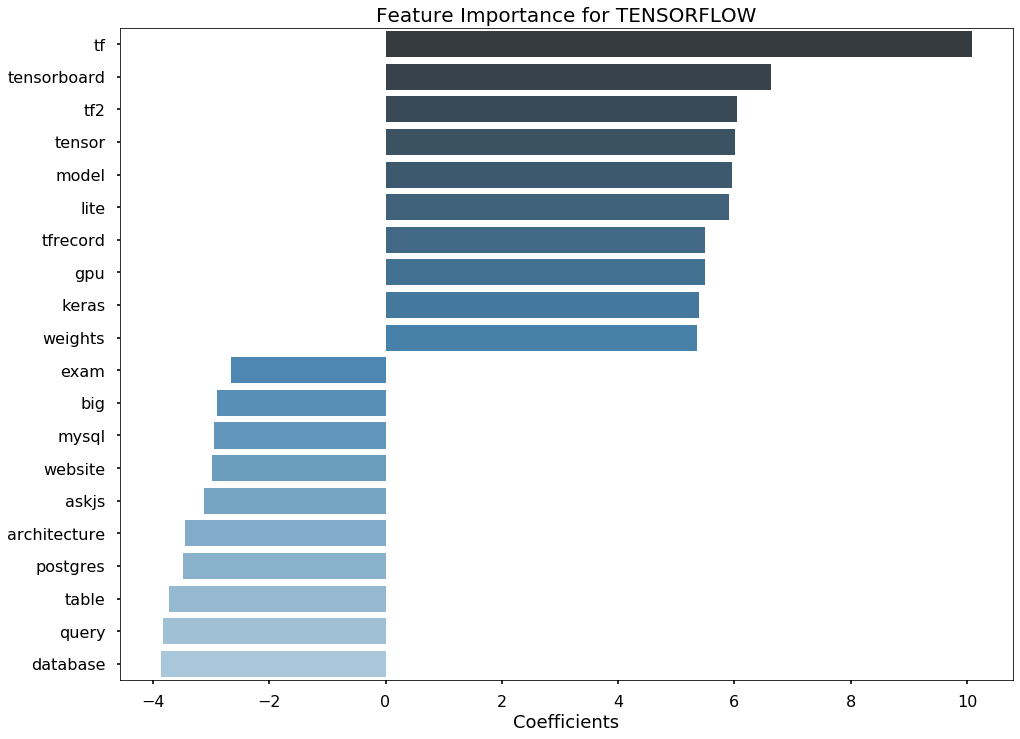

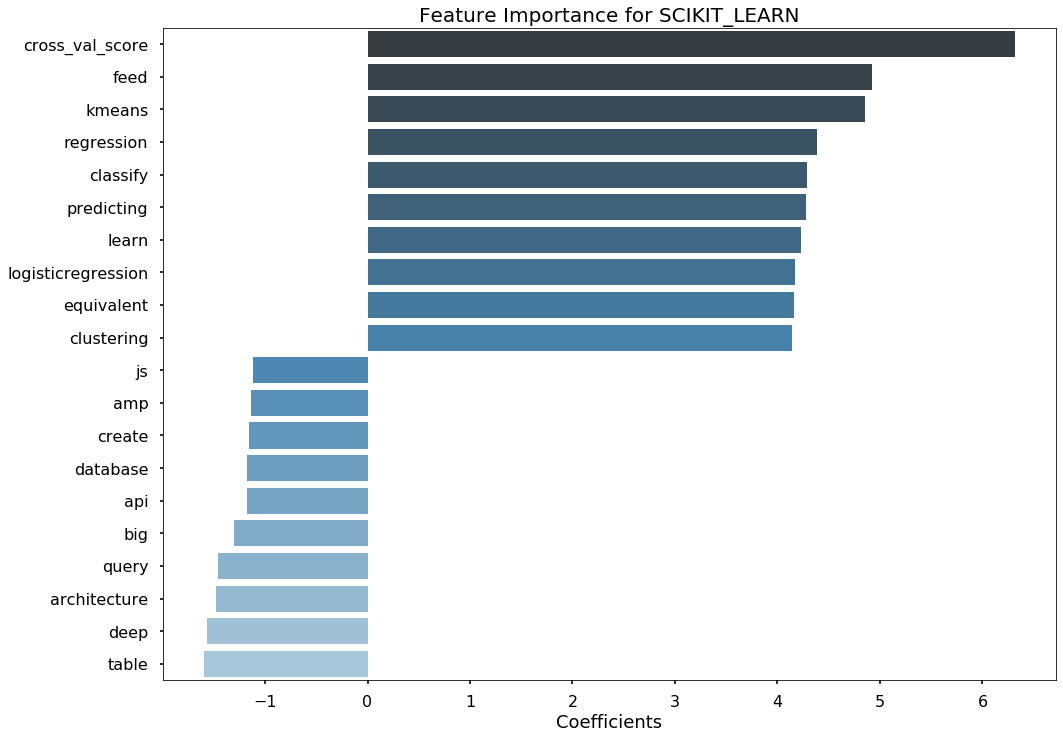

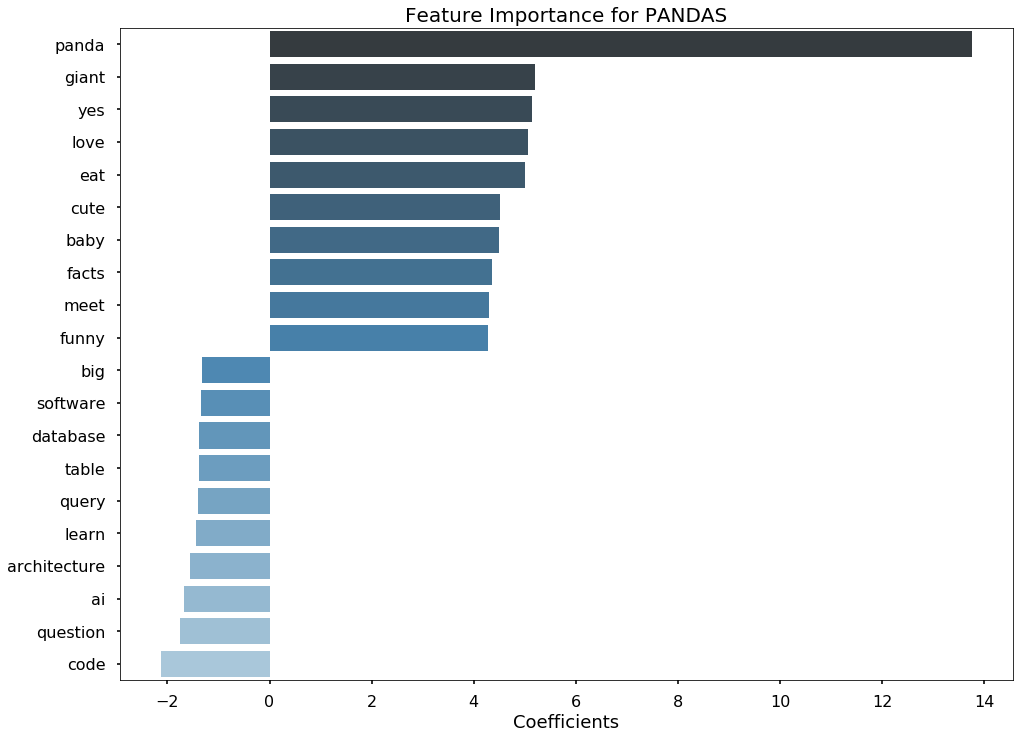

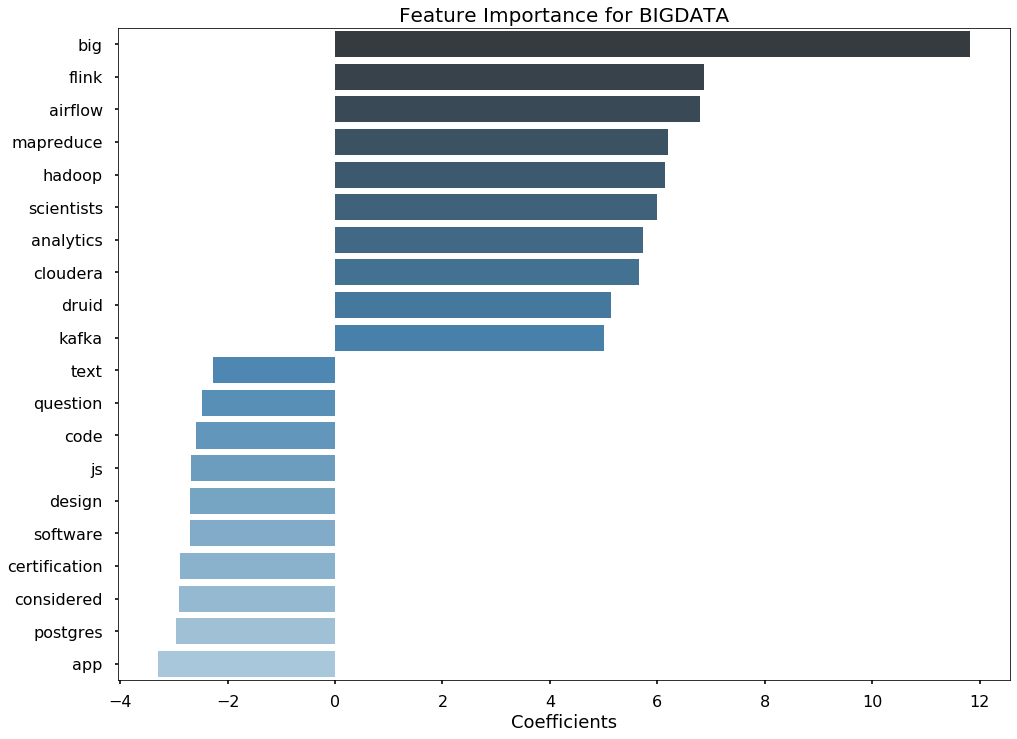

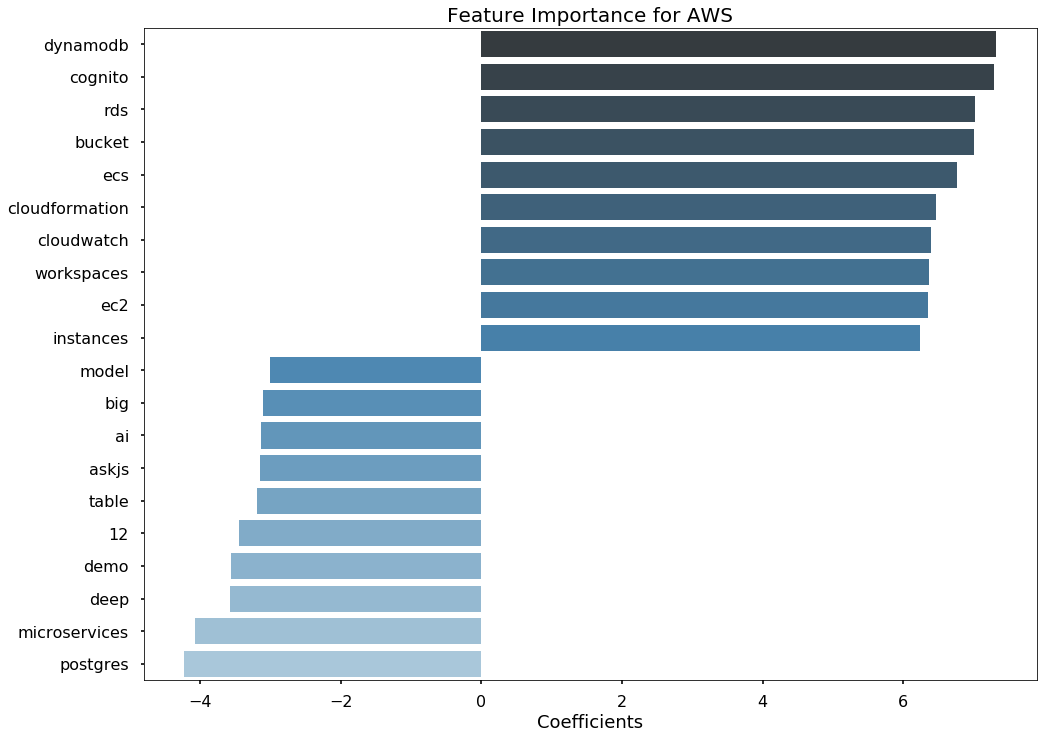

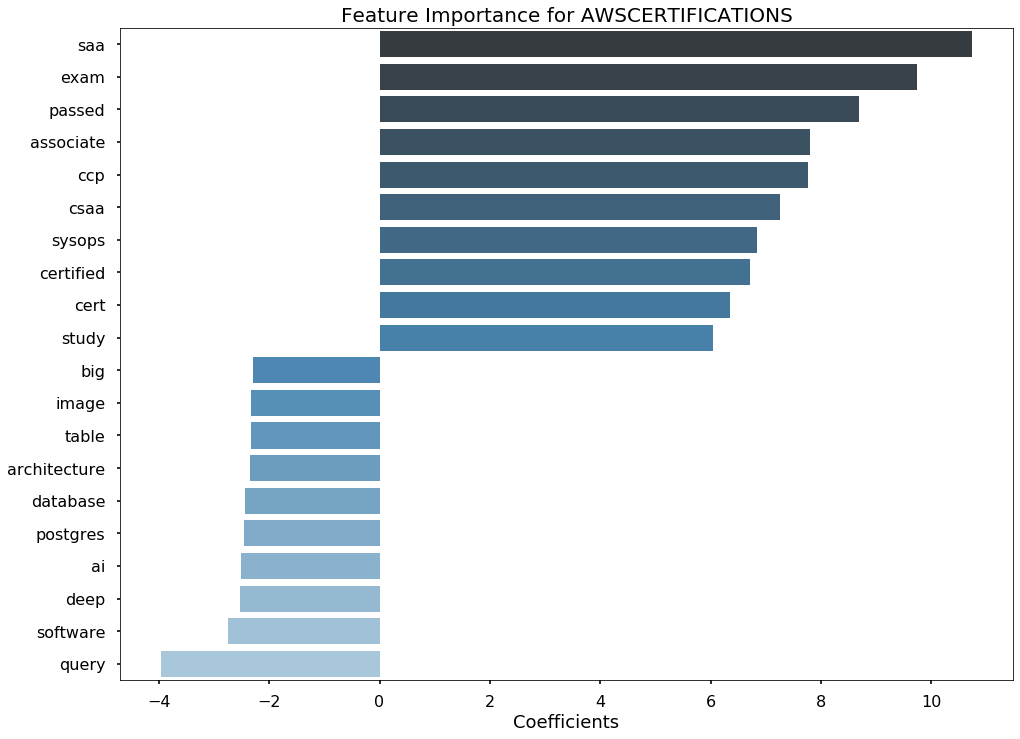

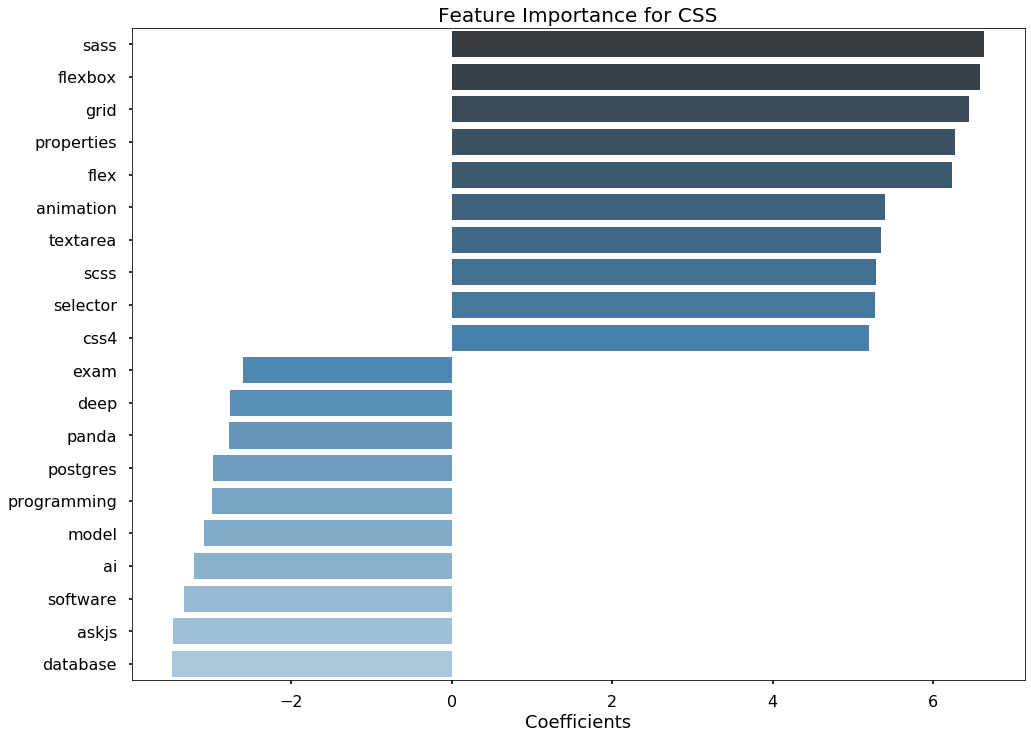

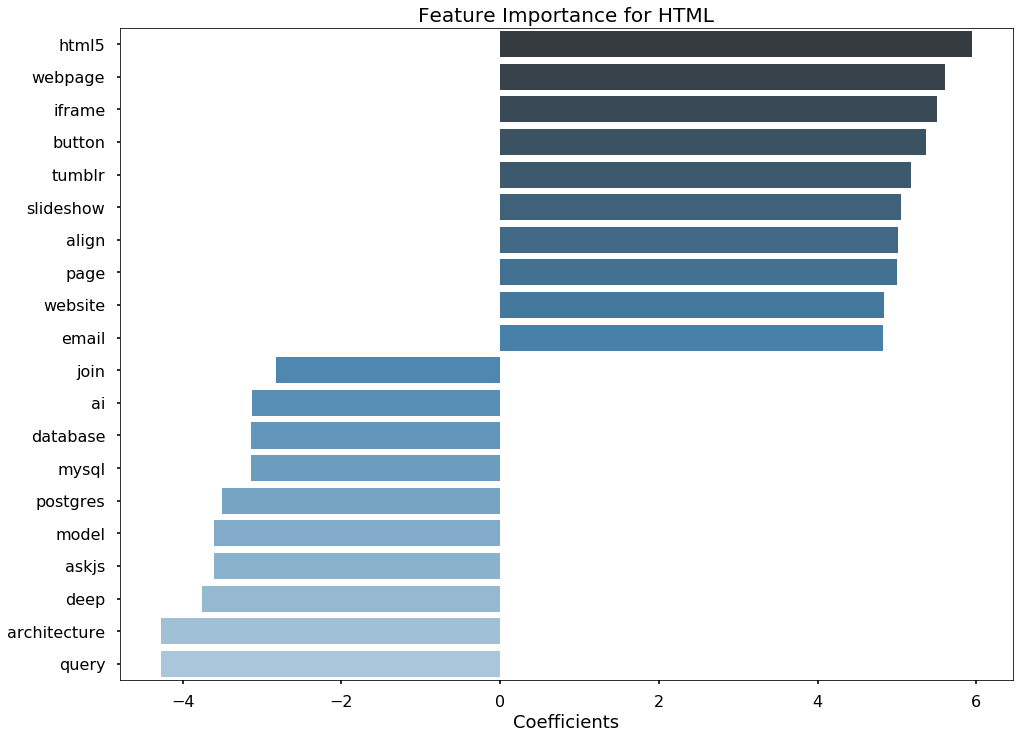

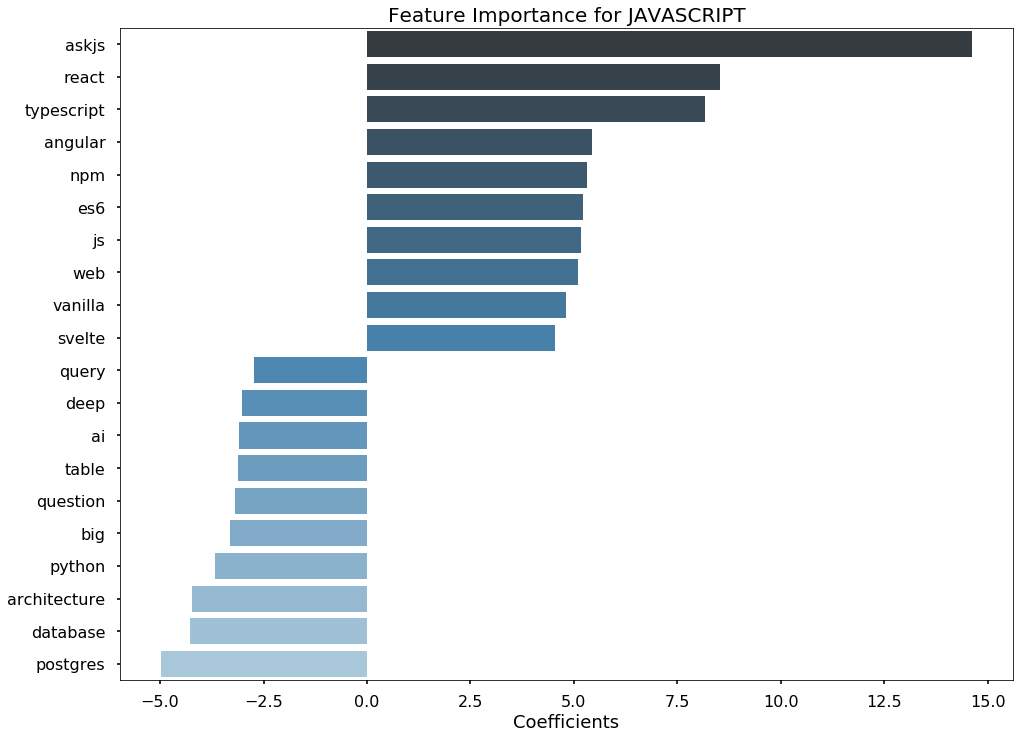

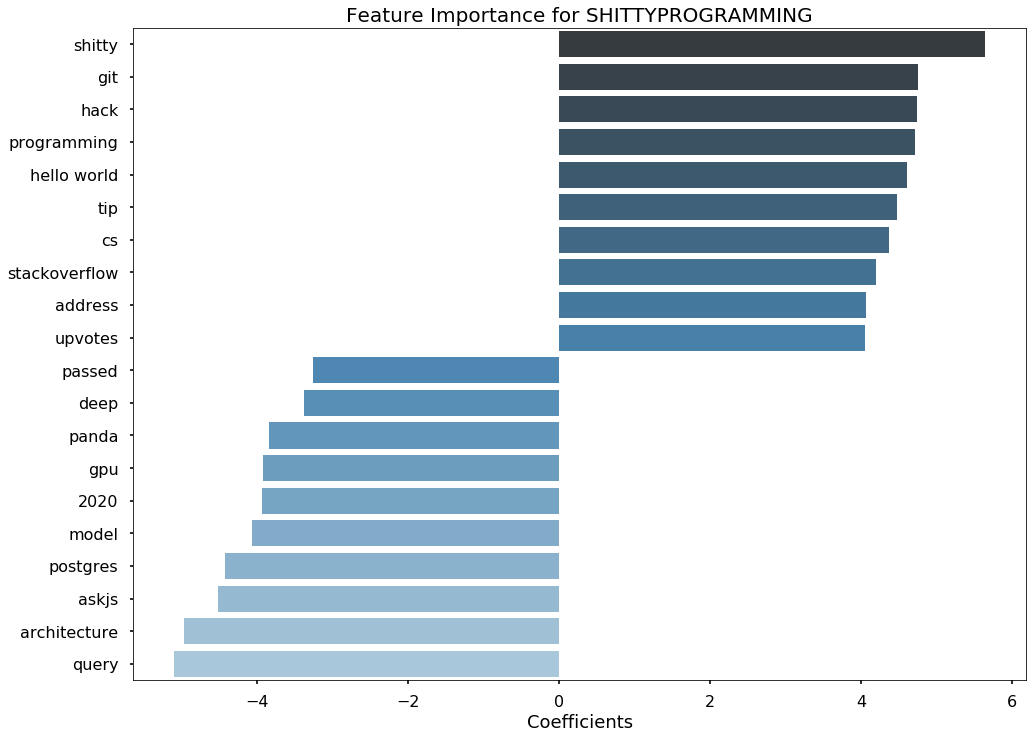

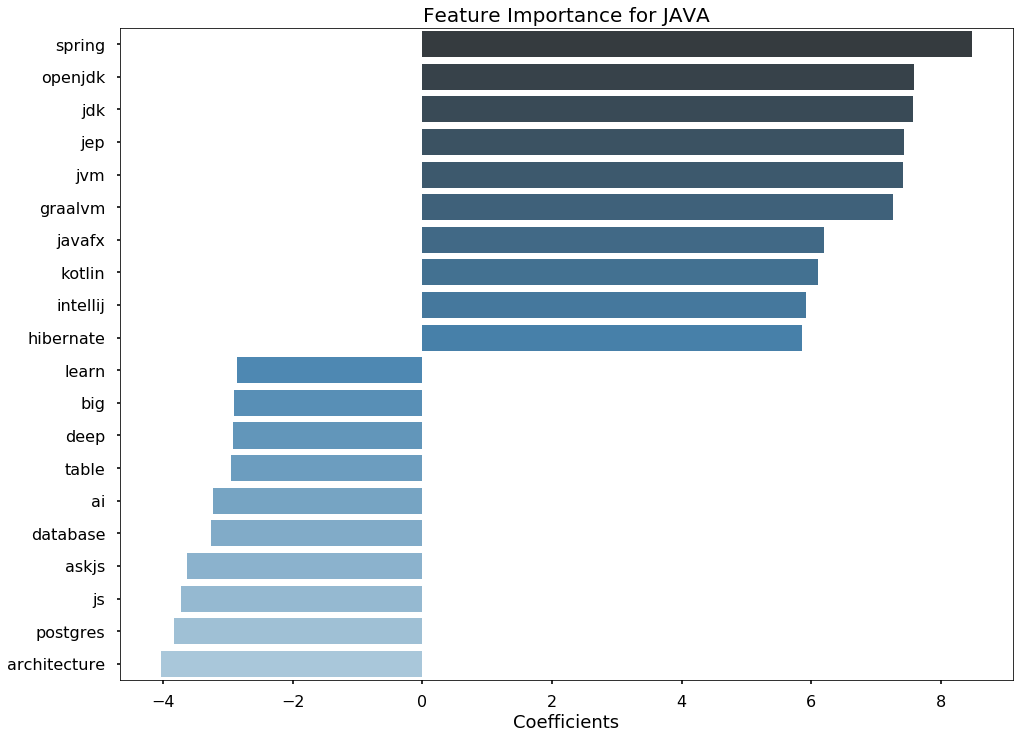

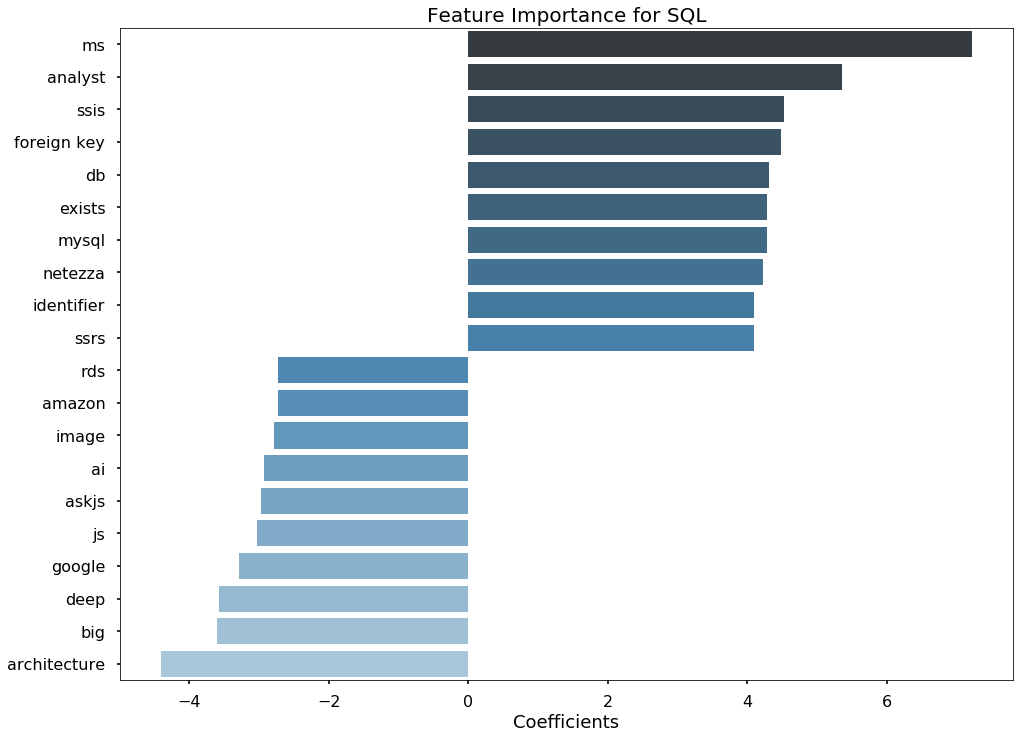

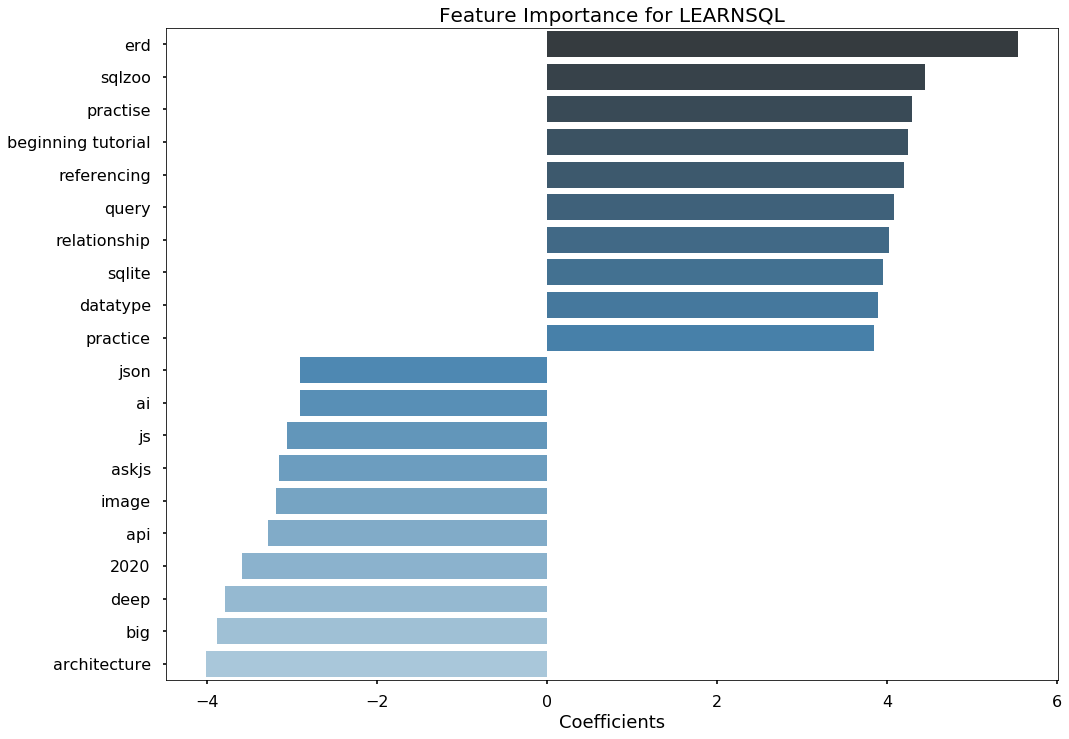

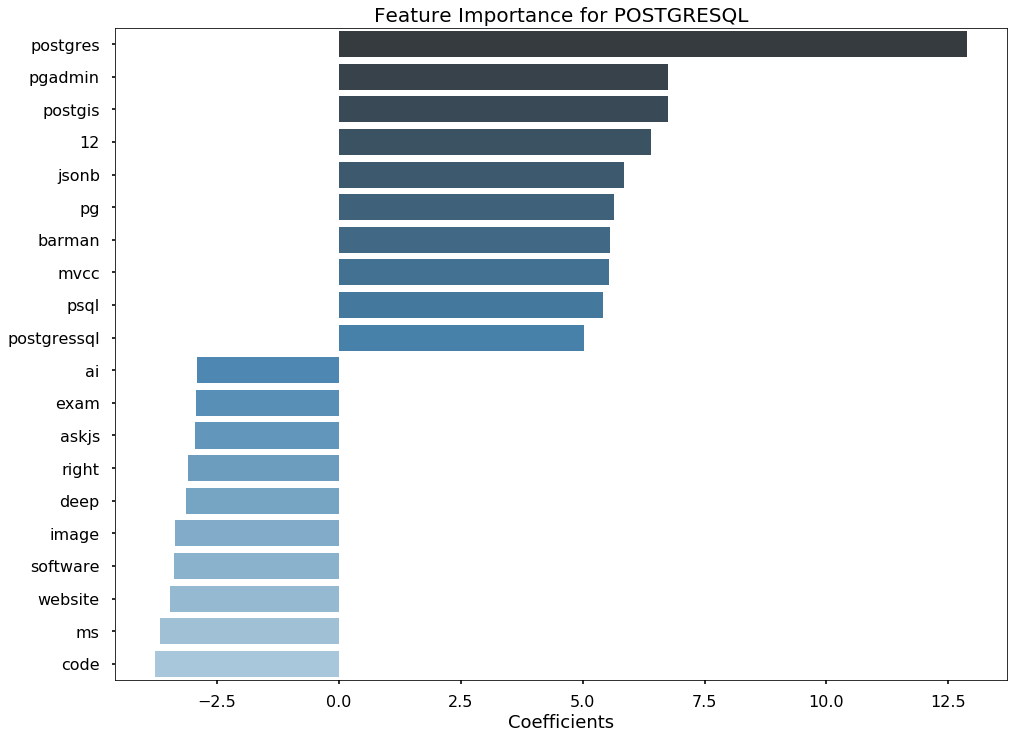

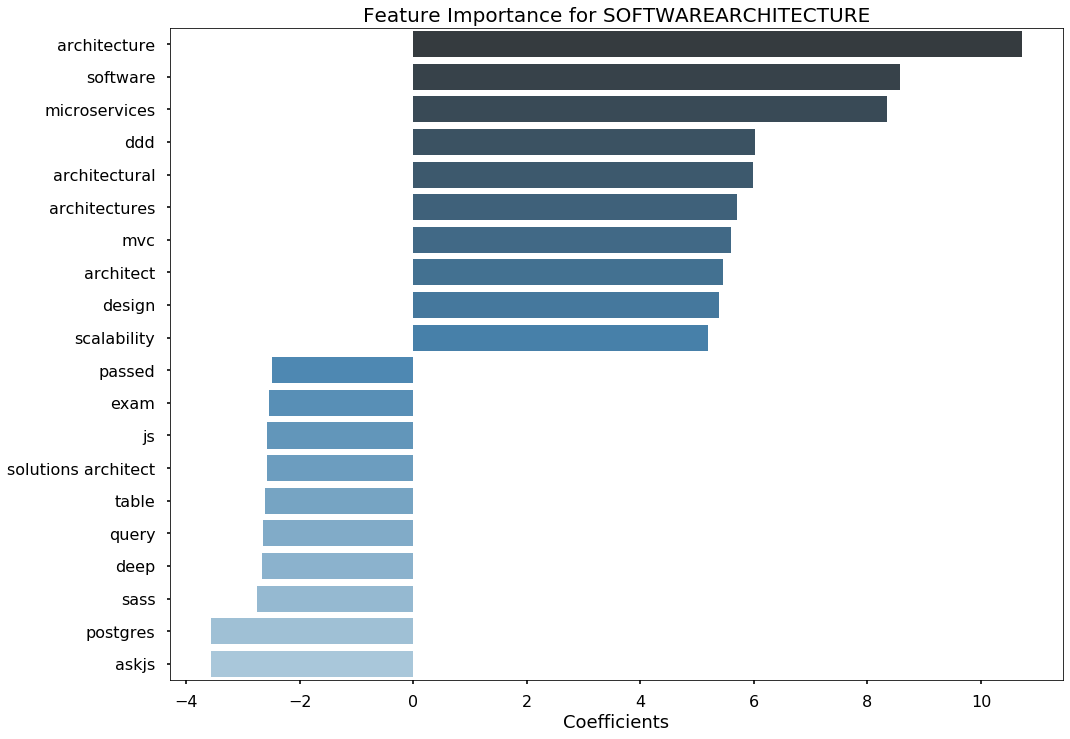

In [15]:
for sub, coef_df in coef_dict.items():

    plt.figure(figsize=(16, 12))
    plt.style.use('seaborn-poster')

    top_10 = coef_df.sort_values(0, ascending=False)[0].head(10)
    bottom_10 = coef_df.sort_values(0, ascending=False)[0].tail(10)
    top_and_bottom = pd.DataFrame(data=top_10.append(bottom_10))
    sns.barplot(x=top_and_bottom[0], y=top_and_bottom.index, palette='Blues_d');

    plt.title(f'Feature Importance for {sub.upper()}', fontsize=20)
    plt.xlabel('Coefficients', fontsize=18)

# Predictions

In [16]:
y_pred = model.predict(X)

In [17]:
y_pred

array([ 0,  0,  0, ..., 15, 15, 15])

In [18]:
y_probs = model.predict_proba(X)

In [19]:
y_probs

array([[2.98441918e-01, 1.03410377e-01, 5.05825596e-03, ...,
        3.07107550e-02, 6.53019541e-02, 2.90579392e-02],
       [3.48813770e-01, 6.04363165e-02, 2.89221935e-01, ...,
        2.49061652e-02, 2.69538931e-02, 1.83657698e-02],
       [6.50679631e-01, 6.70540916e-02, 8.37889039e-03, ...,
        3.51928566e-03, 5.47559323e-03, 1.10203387e-02],
       ...,
       [5.56624148e-03, 8.07862481e-03, 2.92704762e-03, ...,
        7.86221200e-03, 6.23498434e-03, 8.47894365e-01],
       [1.96123508e-03, 8.59976255e-04, 1.45421049e-03, ...,
        9.97059702e-04, 1.26789484e-03, 9.82485353e-01],
       [1.30989416e-02, 3.02142338e-03, 6.81706131e-03, ...,
        4.53283370e-03, 6.53741875e-02, 4.61082709e-01]])

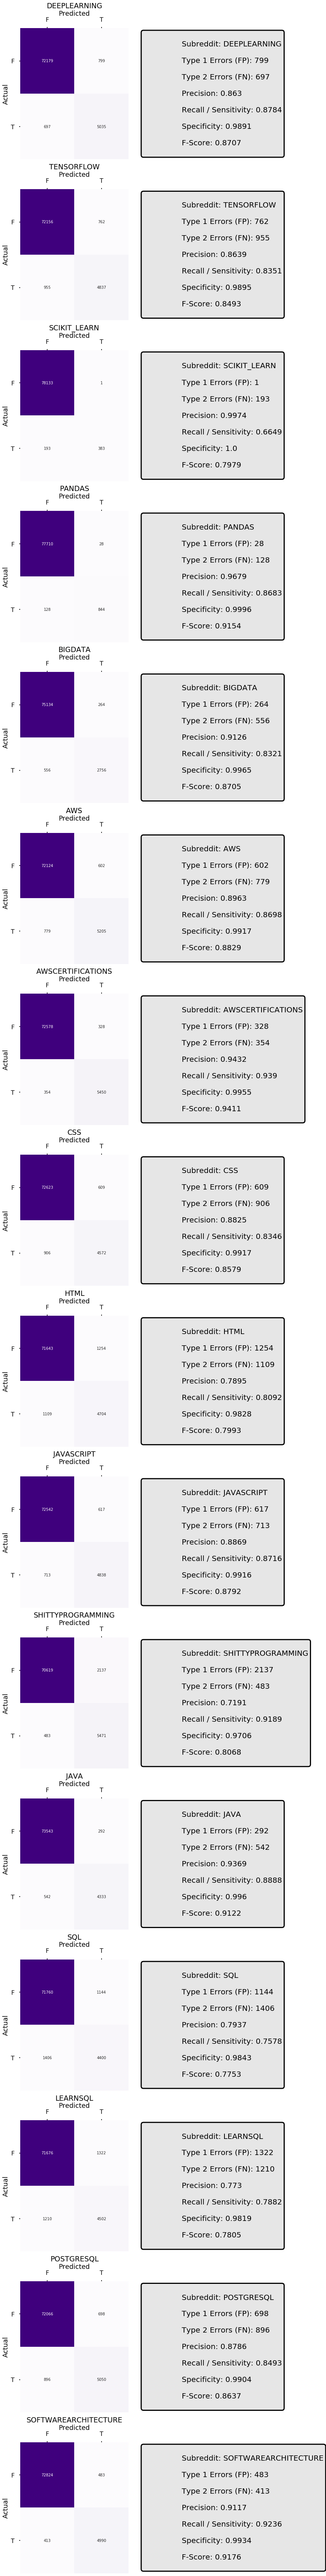

In [20]:
mcm = multilabel_confusion_matrix(y, y_pred)
mtn = mcm[:, 0, 0]
mtp = mcm[:, 1, 1]
mfn = mcm[:, 1, 0]
mfp = mcm[:, 0, 1]

fig, ax = plt.subplots(ncols=2, nrows=len(classes),
                       figsize=(12, 6*len(classes)))

for i, cm in enumerate(mcm):
    df_cm = pd.DataFrame(cm)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    sns.heatmap(df_cm, annot=True, fmt="d", cbar=False,
                cmap='Purples', ax=ax[i, 0])

    ax[i, 0].set_yticklabels(labels=['F', 'T'], rotation='horizontal')
    ax[i, 0].set_xticklabels(labels=['F', 'T'])
    ax[i, 0].xaxis.tick_top()
    ax[i, 0].xaxis.set_label_position('top')
    ax[i, 0].set_title(classes[i].upper())

    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp)
    specificity = tn / (tn + fp)
    recall = tp / (tp + fn)
    fscore = (2 * recall * precision) / (recall + precision)
    
    box_text = f'''
                Subreddit: {classes[i].upper()}\n
                Type 1 Errors (FP): {round(fp,4)}\n
                Type 2 Errors (FN): {round(fn,4)}\n
                Precision: {round(precision, 4)}\n
                Recall / Sensitivity: {round(recall,4)}\n
                Specificity: {round(specificity,4)}\n
                F-Score: {round(fscore,4)}
                '''
    ax[i, 1].text(0.1, 0.5,
                  box_text,
                  bbox=dict(
                            boxstyle="round",
                            ec=('k'),
                            lw=3,
                            fc=(.9,.9,.9),
                           ),
                  horizontalalignment='left',
                  verticalalignment='center',
                  fontsize=20)
    ax[i, 1].set_axis_off()

plt.tight_layout()

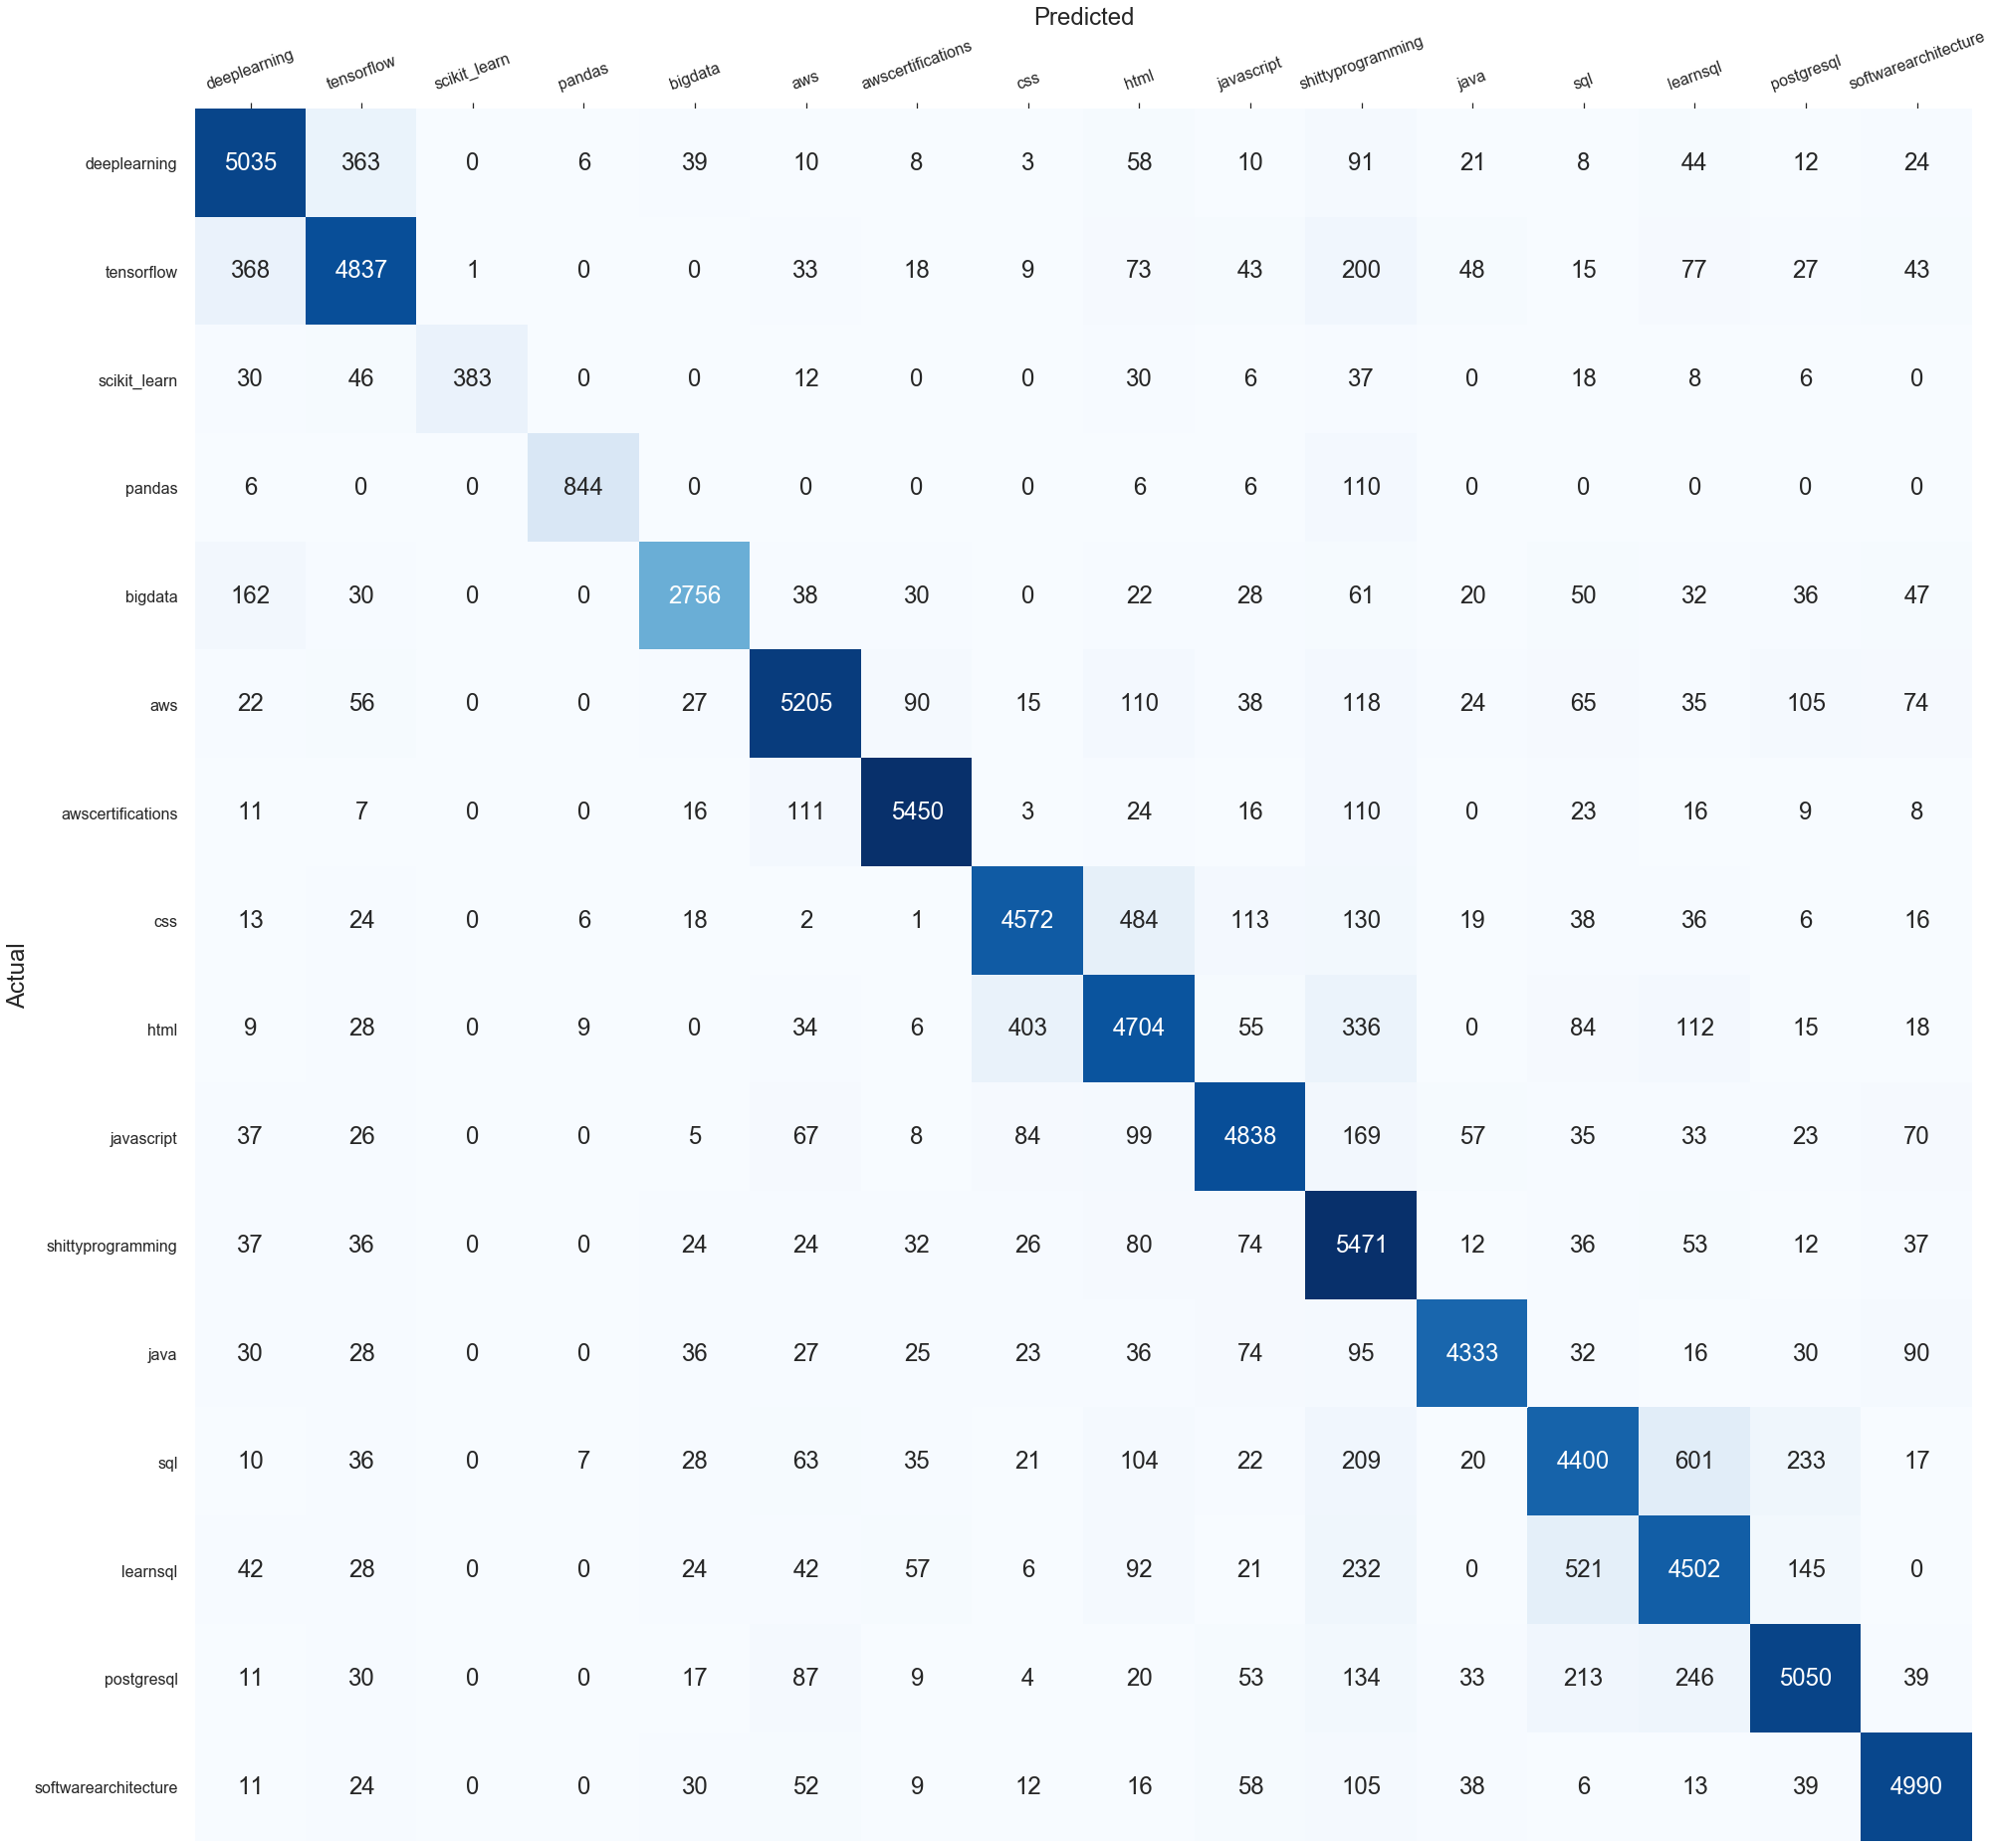

In [23]:
df_cm = pd.DataFrame(data=confusion_matrix(y, y_pred),
                     columns=classes, index=classes)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

fig, ax = plt.subplots(figsize=(2*len(classes),2*len(classes)))

sns.set(font_scale=2)
sns.heatmap(df_cm, 
            annot=True, 
            fmt="d", 
            cbar=False, 
            cmap='Blues', 
            ax=ax, 
#             norm=LogNorm()
           )

fontdict={'fontsize': 16}

ax.set_yticklabels(labels=classes, rotation='horizontal', fontdict=fontdict)
ax.set_xticklabels(labels=classes, rotation=20, fontdict=fontdict)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

In [ ]:
y_probs

In [24]:
print(classification_report(y, y_pred, digits=3, target_names=classes))

                      precision    recall  f1-score   support

        deeplearning      0.863     0.878     0.871      5732
          tensorflow      0.864     0.835     0.849      5792
        scikit_learn      0.997     0.665     0.798       576
              pandas      0.968     0.868     0.915       972
             bigdata      0.913     0.832     0.870      3312
                 aws      0.896     0.870     0.883      5984
   awscertifications      0.943     0.939     0.941      5804
                 css      0.882     0.835     0.858      5478
                html      0.790     0.809     0.799      5813
          javascript      0.887     0.872     0.879      5551
   shittyprogramming      0.719     0.919     0.807      5954
                java      0.937     0.889     0.912      4875
                 sql      0.794     0.758     0.775      5806
            learnsql      0.773     0.788     0.781      5712
          postgresql      0.879     0.849     0.864      5946
softwar

## Which ones are we missing?

In [ ]:
aws_probs = y_probs[:, 0]

In [ ]:
y

In [ ]:
roc_auc_score(y, y_probs[:, 1])

In [ ]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [ ]:
plot_roc_curve(fpr, tpr)

<h1>TODO:</h1>

1. Make it have the roc for each sub, have to get into the original df where subname equals indexes?

In [ ]:
probs_df = pd.DataFrame(data=y_probs, columns=classes)
probs_df['predicted'] = labeler.inverse_transform(y_pred)
probs_df['actual'] = df['subreddit']
probs_df.head(10)

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, label in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
for label in probs_df:
    # only probs for this label
    probs_y = probs_df[label]
    # get the index from df
    label_index = df.index[df['subreddit'] == label].tolist()
    # get matching y values
    true_y = y[label_index]
    print(roc_auc_score(y, probs_y, multi_class='ovr'))

In [ ]:
auc = roc_auc_score(y, y_probs, multi_class='ovr')
auc

In [ ]:
# not multiclass
fpr, tpr, thresholds = roc_curve(y, y_probs[:,1])

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc})', color='r', marker='D')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)', size=16)
plt.ylabel('True Positive Rate (Sensitivity)', size=16)
plt.title('ROC Curve', size=20)
plt.legend(fontsize=14);

In [ ]:
x1 = np.random.normal(0, 0.8, 1000)
x2 = np.random.normal(-2, 1, 1000)
x3 = np.random.normal(3, 2, 1000)
kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=40)
plt.hist(x1, **kwargs) 
plt.hist(x2, **kwargs) 
plt.hist(x3, **kwargs);

In [ ]:
# Create figure.
plt.figure(figsize = (10,7))

# Create histogram of observations.
plt.hist(y_probs, bins=25)

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18);

In [ ]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
hst0 = plt.hist(y_probs[y == 0],
         bins=25,
#          color='b',
         alpha = 0.6,
         label='Technology',)

hst1 = plt.hist(y_probs[y == 1],
         bins=25,
#          color='orange',
         alpha = 0.6,
         label='Science')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = max(hst1[0].max(), hst0[0].max()), # Max of the two highest respective hist values
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Science)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

# Thanks to Matt Brems for the colorful graphs! :)